# ThulasiRam_RuppaKrishnan_HomeWork_2

## Semi-structured Data Processing

#### This program will read in JSON formatted data from a Mongo DB collection. This will be in a format that is structured with lines of data representing one tweet. This program will contain the data as lists of json structures, which are just python dictionaries and lists. The program will do some processing to collect data from some of the fields that will answer the following <br> 1. Top 10 Frequency Hashtags <br> 2. Top 10 Frequency Mentions <br> 3. Top 10 Frequency Urls <br> 4. Top 10 users who has got highest number of friends <br> 5. Top 10 users who has got highest number of followers <br> 6. Top 10 retweets <br> 7. Top 10  favourite tweets

### Import required Libraries

In [23]:
import json
import sys
import pymongo
from bson.json_util import dumps
#import sys
from operator import itemgetter
import re
from tabulate import tabulate
import seaborn as sns
import pandas as pd

### Functions to save data in mongo DB, load from DB, get required attributes from tweets

In [24]:
# This function either starts or adds to an existing database and collection in Mongo
# Parameters:  
#   data - this should be a list of json objects, where each will be a collection element
#      in the DB stored under a unique ID key created by Mongo
#   DBname - the name of the database, either new or existing
#   DBcollection - the name of the collection, either new or existing

def save_to_DB (DBname, DBcollection, data):
    # connect to database server and just let connection errors fail the program
    client = pymongo.MongoClient('localhost', 27017)
    # save the results in a database collection
    #   change names to lowercase because they are not case sensitive
    #   and remove special characters like hashtags and spaces (other special characters may also be forbidden)
    DBname = DBname.lower()
    DBname = DBname.replace('#', '')
    DBname = DBname.replace(' ', '')
    DBcollection = DBcollection.lower()
    DBcollection = DBcollection.replace('#', '')
    DBcollection = DBcollection.replace(' ', '')

    # use the DBname and collection, which will create if not existing
    db = client[DBname]
    collection = db[DBcollection]   
        
    # add the data to the database
    collection.insert_many(data)
    print("Saved", len(data), "documents to DB collection", DBname, DBcollection)

# This function gets data from an existing DB and collection
# Parameters:  
#   DBname and DBcollection- the name of the database and collection, either new or existing
# Result:
#   data - returns all the data in the collection as a list of JSON objects

def load_from_DB (DBname, DBcollection):
    # connect to database server and just let connection errors fail the program
    client = pymongo.MongoClient('localhost', 27017)
    # use the DBname and collection, which will create if not existing
    db = client[DBname]
    collection = db[DBcollection]    
        
    # get all the data from the collection as a cursor
    docs = collection.find()
    #  convert the cursor to a list
    docs_bson = list(docs)
    docs_json_str = [dumps(doc) for doc in docs_bson]
    docs_json = [json.loads(doc) for doc in docs_json_str]
    return docs_json

# this program contains a function to return lists of some twitter entities
# for each tweet, this function returns lists of the entities:  mentions, hashtags, URLs , user friends and followers count , user retweets and favourites
# Parameter:  a tweet (as a Twitter json object)
# Result:  3 lists of the above entities
def get_entities(tweet):
    # make sure this is a tweet by checking that it has the 'entities' key
    if 'entities' in tweet.keys():
        # list of mentions comes from the 'screen_name' field of each user_mention
        mentions = [user_mention['screen_name'] for user_mention in tweet['entities']['user_mentions']]
        
        # list of hashtags comes from the 'text' field of each hashtag
        hashtags = [hashtag['text'] for hashtag in tweet['entities']['hashtags']]    
    
        # list of urls can come either from the 'url' field  or 'expanded_url' field of each url
        urls = [urlitem['url'] for urlitem in tweet['entities']['urls']]    
        urls = urls + [urlitem['expanded_url'] for urlitem in tweet['entities']['urls']]
        
    else:
        # if no entities key, return empty lists
        mentions= []
        hashtags =[]
        urls = []

    if 'text' in tweet.keys():
        text=re.sub('RT\s@[^\s]+','',tweet['text'])
    else:
        text=[]
        
    if 'retweet_count' in tweet.keys():
        retweet_count=tweet['retweet_count']
    else:
        retweet_count=[]

    if 'favorite_count' in tweet.keys():
        favorite_count=tweet['favorite_count']
    else:
        favorite_count=[]
        
    if 'user' in tweet.keys():
        
        user=tweet['user']['name']
        friends_count=tweet['user']['friends_count']
        followers_count=tweet['user']['followers_count']
    
    else:
        # if no user key, return empty lists
        user= []
        friends_count =[]
        followers_count = []
        
    return mentions,hashtags,urls,user,friends_count,followers_count,text,retweet_count,favorite_count


### Main program starts here which process the retrieved data and stores the sorted data in a dictionary

In [25]:
DBname = 'twitter_db1'
DBcollection = 'tweets_coll'
limit = 10
filename = 'C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 652\\Week8\\bball_mm2.txt'  

# get the data from the file
fload = open(filename, encoding='utf-8')
resultString = fload.read()
# loads converts from a string back to a json structure
doclist = json.loads(resultString)  
print ("Read", len(doclist), "from file:", filename)

# in case this was saved from a database, we delete the database id key _id, so that DB will assign unique key
for doc in doclist:
    if '_id' in doc.keys():
        del doc['_id']

# use the save and load functions in this program
save_to_DB(DBname, DBcollection, doclist)

# load all the tweets
tweet_results = load_from_DB(DBname, DBcollection)

# Create a frequency dictionary of the hashtags, 
#   a dictionary where the keys are hashtags and the values are the frequency (count)
hashtag_fd = {}
mentions_fd ={}
urls_fd = {}
retweet_fd={}
favourite_fd={}
friends_fd={}
followers_fd={}

for tweet in tweet_results:
    # get the three entity lists from this tweet
    #print(tweet)
    (mentions,hashtags,urls,user,friends_count,followers_count,text,retweet_count,favorite_count) = get_entities(tweet)
    # put the hashtags in the frequency dictionary
    for tag in hashtags:
        # if the tag is not yet in the dictionary, add it with the count of 1
        if not tag in hashtag_fd:
            hashtag_fd[tag] = 1
        else:
            # otherwise, add 1 to the count that is already there
            hashtag_fd[tag] += 1

    # put the mentions in the frequency dictionary
    for mention in mentions:
        # if the mention is not yet in the dictionary, add it with the count of 1
        if not mention in mentions_fd:
            mentions_fd[mention] = 1
        else:
            # otherwise, add 1 to the count that is already there
            mentions_fd[mention] += 1

    # put the mentions in the frequency dictionary
    for url in urls:
        # if the mention is not yet in the dictionary, add it with the count of 1
        if not url in urls_fd:
            urls_fd[url] = 1
        else:
            # otherwise, add 1 to the count that is already there
            urls_fd[url] += 1

    retweet_fd[text]=max(retweet_fd.get(text,0),retweet_count)
    favourite_fd[text]=max(favourite_fd.get(text,0),favorite_count)

    friends_fd[user]=max(friends_fd.get(user,0),friends_count)
    followers_fd[user]=max(followers_fd.get(user,0),followers_count)

# sort the dictionary by frequency values, returns a list of pairs of words and frequencies
#   in decreasing order
hashtags_sorted = sorted(hashtag_fd.items(), key=itemgetter(1), reverse=True)
mentions_sorted = sorted(mentions_fd.items(), key=itemgetter(1), reverse=True)
urls_sorted = sorted(urls_fd.items(), key=itemgetter(1), reverse=True)
retweet_sorted = sorted(retweet_fd.items(), key=itemgetter(1), reverse=True)
favourite_sorted = sorted(favourite_fd.items(), key=itemgetter(1), reverse=True)
friends_sorted = sorted(friends_fd.items(), key=itemgetter(1), reverse=True)
followers_sorted = sorted(followers_fd.items(), key=itemgetter(1), reverse=True)


Read 2000 from file: C:\Users\rkrishnan\Documents\01 Personal\MS\IST 652\Week8\bball_mm2.txt
Saved 2000 documents to DB collection twitter_db1 tweets_coll


### 1. print out the top number of Hashtags with frequencies

Top 10 Frequency Hashtags
Hashtag                        Frequency
---------------------------  -----------
marchmadness                         991
MarchMadness                         942
FinalFour                            149
UNC                                   81
mondaymotivation                      61
WorldTheatreDay                       29
ImproveYourLoveLifeIn5Words           29
SouthCarolina                         25
finalfour                             22
basketball                            22


[Text(0, 0, 'marchmadness'),
 Text(0, 0, 'MarchMadness'),
 Text(0, 0, 'FinalFour'),
 Text(0, 0, 'UNC'),
 Text(0, 0, 'mondaymotivation'),
 Text(0, 0, 'WorldTheatreDay'),
 Text(0, 0, 'ImproveYourLoveLifeIn5Words'),
 Text(0, 0, 'SouthCarolina'),
 Text(0, 0, 'finalfour'),
 Text(0, 0, 'basketball')]

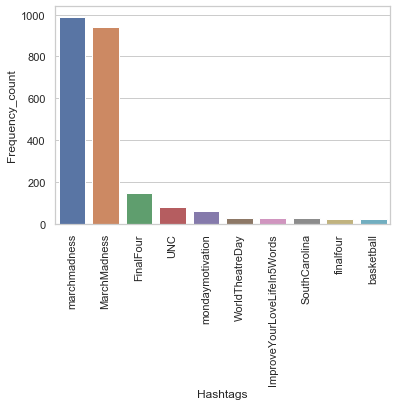

In [27]:

# print out the top number of Hashtags with frequencies
print("Top", limit, "Frequency Hashtags")
#    for (word, frequency) in hashtags_sorted[:limit]:
#        print (word, frequency)
print(tabulate(hashtags_sorted[:limit],headers=['Hashtag', 'Frequency']))

sns.set(style="whitegrid")
ax = sns.barplot(x="Hashtags", y="Frequency_count", data=pd.DataFrame(hashtags_sorted[:limit],columns=['Hashtags','Frequency_count']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


### 2. Print out the top number of Mentions with frequencies

Top 10 Frequency Mentions
Mentions          Frequency
--------------  -----------
HowardWKYT              507
BleacherReport          180
marchmadness            141
WhistleSports            82
SamuelGrubbs1            74
GamecockMBB              53
GamecockWBB              23
NBAenlinea               23
UofSC                    20
ForAmerica               16


[Text(0, 0, 'HowardWKYT'),
 Text(0, 0, 'BleacherReport'),
 Text(0, 0, 'marchmadness'),
 Text(0, 0, 'WhistleSports'),
 Text(0, 0, 'SamuelGrubbs1'),
 Text(0, 0, 'GamecockMBB'),
 Text(0, 0, 'GamecockWBB'),
 Text(0, 0, 'NBAenlinea'),
 Text(0, 0, 'UofSC'),
 Text(0, 0, 'ForAmerica')]

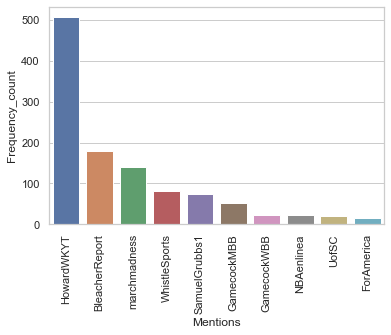

In [28]:
# print out the top number of Mentions with frequencies
print("Top", limit, "Frequency Mentions")
#    for (word, frequency) in mentions_sorted[:limit]:
#        print (word, frequency)
print(tabulate(mentions_sorted[:limit],headers=['Mentions', 'Frequency']))
ax = sns.barplot(x="Mentions", y="Frequency_count", data=pd.DataFrame(mentions_sorted[:limit],columns=['Mentions','Frequency_count']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### 3. Print out the top number of urls with frequencies

Top 10 Frequency urls
Urls                                                            Frequency
------------------------------------------------------------  -----------
http://bit.ly/2mKgOvQ                                                  13
http://SneekAroundToys.com                                             11
https://t.co/nN5SKLC80V                                                10
https://t.co/p3GnvolvQ2                                                10
http://bit.ly/2oaDJ3V                                                  10
https://t.co/1wpXbeONPL                                                 7
http://ellen.tv/2nEl8A5                                                 7
https://t.co/GKpEpJgwGA                                                 6
https://twitter.com/MarchMadnessTV/status/573661396400910336            6
https://t.co/iQK7qinvOD                                                 5


[Text(0, 0, 'http://bit.ly/2mKgOvQ'),
 Text(0, 0, 'http://SneekAroundToys.com'),
 Text(0, 0, 'https://t.co/nN5SKLC80V'),
 Text(0, 0, 'https://t.co/p3GnvolvQ2'),
 Text(0, 0, 'http://bit.ly/2oaDJ3V'),
 Text(0, 0, 'https://t.co/1wpXbeONPL'),
 Text(0, 0, 'http://ellen.tv/2nEl8A5'),
 Text(0, 0, 'https://t.co/GKpEpJgwGA'),
 Text(0, 0, 'https://twitter.com/MarchMadnessTV/status/573661396400910336'),
 Text(0, 0, 'https://t.co/iQK7qinvOD')]

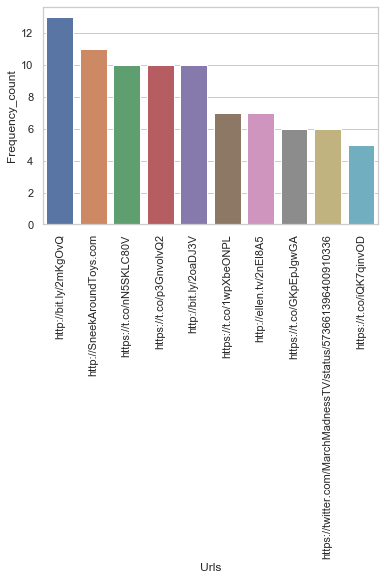

In [29]:
# print out the top number of urls with frequencies
print("Top", limit, "Frequency urls")
#    for (word, frequency) in urls_sorted[:limit]:
#        print (word, frequency)
print(tabulate(urls_sorted[:limit],headers=['Urls', 'Frequency']))
ax = sns.barplot(x="Urls", y="Frequency_count", data=pd.DataFrame(urls_sorted[:limit],columns=['Urls','Frequency_count']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### 4. Print out the top users with highest number of friends

Top 10  users who has got highest number of friends
Users                 friends_count
------------------  ---------------
Producer 9-0                 831550
Social Stocks Now            266021
Social Start Now             248371
SNFB, Inc.                   143898
Author Lee Jackson            93320
Tweet Social News             89774
SneekAround.com               78291
Esri                          75359
Social Start News             72314
CollegeBB News                65210


[Text(0, 0, 'Producer 9-0'),
 Text(0, 0, 'Social Stocks Now'),
 Text(0, 0, 'Social Start Now'),
 Text(0, 0, 'SNFB, Inc.'),
 Text(0, 0, 'Author Lee Jackson'),
 Text(0, 0, 'Tweet Social News'),
 Text(0, 0, 'SneekAround.com'),
 Text(0, 0, 'Esri'),
 Text(0, 0, 'Social Start News'),
 Text(0, 0, 'CollegeBB News')]

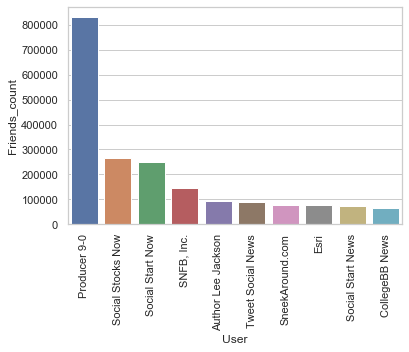

In [30]:
# print out the top users with highest number of friends
print("Top", limit, " users who has got highest number of friends")
#    for (word, frequency) in friends_sorted[:limit]:
#        print (word, frequency)
print(tabulate(friends_sorted[:limit],headers=['Users', 'friends_count']))
ax = sns.barplot(x="User", y="Friends_count", data=pd.DataFrame(friends_sorted[:limit],columns=['User','Friends_count']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


### 5. Print out the top users with highest number of followers

Top 10  users who has got highest number of followers
Users                 followers_count
------------------  -----------------
John Legere                   3888114
Producer 9-0                  1067910
Social Stocks Now              860166
NBC Sports                     806851
Social Start Now               688738
LALATE                         480490
Athlete Swag                   280413
Tweet Social News              218371
Tim Scott                      212858
Author Lee Jackson             195833
****************************************************************************************************


[Text(0, 0, 'John Legere'),
 Text(0, 0, 'Producer 9-0'),
 Text(0, 0, 'Social Stocks Now'),
 Text(0, 0, 'NBC Sports'),
 Text(0, 0, 'Social Start Now'),
 Text(0, 0, 'LALATE'),
 Text(0, 0, 'Athlete Swag'),
 Text(0, 0, 'Tweet Social News'),
 Text(0, 0, 'Tim Scott'),
 Text(0, 0, 'Author Lee Jackson')]

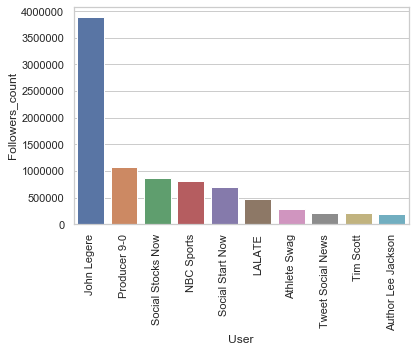

In [31]:
# print out the top users with highest number of followers
print("Top", limit, " users who has got highest number of followers")
#    for (word, frequency) in followers_sorted[:limit]:
#        print (word, frequency)
print(tabulate(followers_sorted[:limit],headers=['Users', 'followers_count']))
print(100*'*')
ax = sns.barplot(x="User", y="Followers_count", data=pd.DataFrame(followers_sorted[:limit],columns=['User','Followers_count']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### 6. Print out the top tweets with highest number of retweets

Top 10  retweets
Tweet                                                                                                                            retweets_count
-----------------------------------------------------------------------------------------------------------------------------  ----------------
And then there were four... #MarchMadness https://t.co/0MbxpgAuUC                                                                        13495
#MarchMadness #Season #Carti                                                                                                             11652
- tell a friend * rip Mac Dre https://t.co/TZlA6be18M
#MarchMadness is taking over 📝🏀 (via @SamuelGrubbs1) https://t.co/1df7nbb5le                                                           10356
The final seconds of the Kentucky-North Carolina game was an emotional roller coaster for Big Blue fans. #marchmadness #WKY…              9741
Yo... 😳                                                                

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

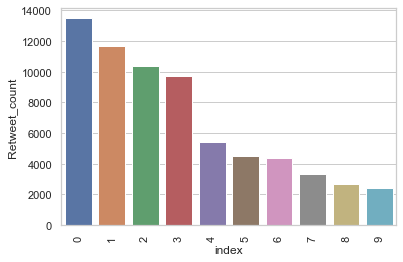

In [32]:
# print out the top tweets with highest number of retweets
print("Top", limit, " retweets")
#    for (word, frequency) in retweet_sorted[:limit]:
#        print (word, frequency)
print(tabulate(retweet_sorted[:limit],headers=['Tweet', 'retweets_count']))
ax = sns.barplot(x="index", y="Retweet_count", data=pd.DataFrame(retweet_sorted[:limit],columns=['Tweet','Retweet_count']).reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### 7. Print out the top tweets with highest number of favourites

Top 10  favourites
Tweet                                                                                                                                         favourites_count
------------------------------------------------------------------------------------------------------------------------------------------  ------------------
When you perfectly time the #UNC buzzer beater 😱🏀 #MarchMadness                                                                                           77

(via:@SamuelGrubbs1 ) https://t.co/Ol2ibpZjB4
South Carolina had .3% chance to make the Final Four on Selection Sunday #MarchMadness                                                                      72
Congrats to @GamecockMBB on making it to #finalfour! Cheering for @GamecockWBB tonight! #GoGamecocks #MarchMadness https://t.co/OLiIk0JC6U                  55
Vegas odds to win the National Championship                                                                                                  

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

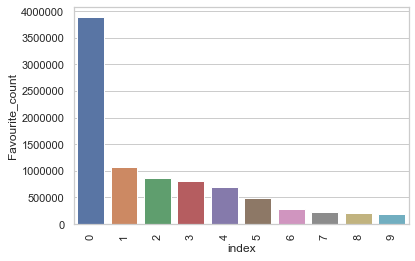

In [33]:

# print out the top tweets with highest number of favourites
print("Top", limit, " favourites")
#    for (word, frequency) in favourite_sorted[:limit]:
#        print (word, frequency)
print(tabulate(favourite_sorted[:limit],headers=['Tweet', 'favourites_count']))
ax = sns.barplot(x="index", y="Favourite_count", data=pd.DataFrame(followers_sorted[:limit],columns=['Tweet','Favourite_count']).reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

